In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.experiments.WPtwo.onen.plot import plot_1n_osc, plot_1n_osc_noisy


# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/1n")
dir = os.path.join(pickledir, "images_1n_aln_w1")

print(dir)

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/1n/images_1n_aln_w1


In [59]:
w_array_list = []

warr = 1e-2 * np.arange(1.0, 11., 1.)

w_array_list.append(warr)
w_array_list.append(warr)
w_array_list.append(warr)
w_array_list.append(warr)

In [60]:
data = dict()
p_names = ["A", "B", "C", "D"]
coords = [[0., 0.7], [1., 1.5], [2., 0.8], [2.5, 1.8]]

for i in range(len(p_names)):

    p = p_names[i]
    data[p] = dict()
    data[p]["coordinates"] = coords[i]
    data[p]["target_period"] = 20.
    data[p]["control"] = [None for x in range(len(w_array_list[i]))]
    data[p]["state"] = [None for x in range(len(w_array_list[i]))]
    data[p]["w1"] = w_array_list[i].copy()
    data[p]["init_state"] = None

N = 1
model = ALNModel()
dt = model.params.dt

In [61]:
testd = 20000.
model.params.duration = testd
test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
model.params["ext_exc_current"] = test_input
model.params["ext_inh_current"] = test_input

for i in range(len(p_names)):
    
    p = data[p_names[i]]["coordinates"]
    print("pind = ", i, p_names[i], p)

    model.params.mue_ext_mean = p[0]
    model.params.mui_ext_mean = p[1]
    model.run()

    data[p_names[i]]["init_state"] = getfinalstate(model)

pind =  0 A [0.0, 0.7]
pind =  1 B [1.0, 1.5]
pind =  2 C [2.0, 0.8]
pind =  3 D [2.5, 1.8]


In [62]:
controlmat = np.zeros((N,4))
controlmat[:,0] = 1.

costmat = np.zeros((N, 3))
costmat[:,0] = 1.

duration = 160.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

it = 5
maxstr = 5
pr = np.arange(0,101,10)

In [71]:
for i in range(len(p_names)):
    print(i)

    p = p_names[i]
    print(data[p]["w1"][0])
    data[p]["w1"] *= 2
    print(data[p]["w1"][0])

0
0.1
0.2
1
0.1
0.2
2
0.1
0.2
3
0.1
0.2


In [72]:
for i in range(len(p_names)):
    
    p = data[p_names[i]]["coordinates"]
    print("pind = ", i, p_names[i], p)

    setinitstate(model, data[p_names[i]]["init_state"])

    model.params.duration = duration
    model.params["ext_exc_current"] = zero_control[:,0,:]
    model.params["ext_inh_current"] = zero_control[:,0,:]
    model.params.mue_ext_mean = p[0]
    model.params.mui_ext_mean = p[1]
    model.run()

    target_period = data[p_names[i]]["target_period"]
    int0 = 200
    int1 = int0 + int(target_period/dt)*6

    for iw in range(len(data[p_names[i]]["w1"])):

        w = data[p_names[i]]["w1"][iw]
        print("iw = ", iw, w)

        model_controlled = oc_aln.OcAln(model, target_period, print_array=pr,
                cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
        model_controlled.step = 1-2
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_1"] = w
        model_controlled.weights["w_f"] = 1.

        model_controlled.maximum_control_strength = maxstr

        if True:
            if type(data[p_names[i]]["control"][iw]) != type(None):
                model_controlled.control = data[p_names[i]]["control"][iw].copy()
                model_controlled.update_input()

        if i in [0,1] and type(data[p_names[i]]["control"][iw]) == type(None):
            model_controlled.control[0,0,int0:int1+1] = 2. * (1. +  np.sin(2. * np.pi * np.arange(0, target_period*6+dt, dt)/target_period))
            model_controlled.update_input()

        model_controlled.step = 10.**(-2)
        model_controlled.optimize(it)

        if True:
            for l in range(1):
                for k in [-4,-1,2]:
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10.**(k)
                    model_controlled.optimize(it)

        data[p_names[i]]["control"][iw] = model_controlled.control.copy()
        data[p_names[i]]["state"][iw] = model_controlled.get_xs()

    with open(os.path.join(pickledir, 'osc_1n_aln_w1.pickle'), 'wb') as f:
        pickle.dump(data, f)

pind =  0 A [0.0, 0.7]
iw =  0 0.2
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 2.717882159692124
Converged in iteration 1 with cost 2.717882159692124
Final cost : 2.717882159692124
Compute control for a deterministic system
Cost in iteration 0: 2.717882159692124
Converged in iteration 1 with cost 2.717882159692124
Final cost : 2.717882159692124
Compute control for a deterministic system
Cost in iteration 0: 2.717882159692124
Converged in iteration 1 with cost 2.717882159692124
Final cost : 2.717882159692124
Compute control for a deterministic system
Cost in iteration 0: 2.717882159692124
Converged in iteration 1 with cost 2.717882159692124
Final cost : 2.717882159692124
iw =  1 0.4
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 54.33309978178924
Final cost : 53.08564443459055
Compute control for a deterministic system
Cost in iteration 0: 53.08564443459055


/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/lena/.local/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant fi

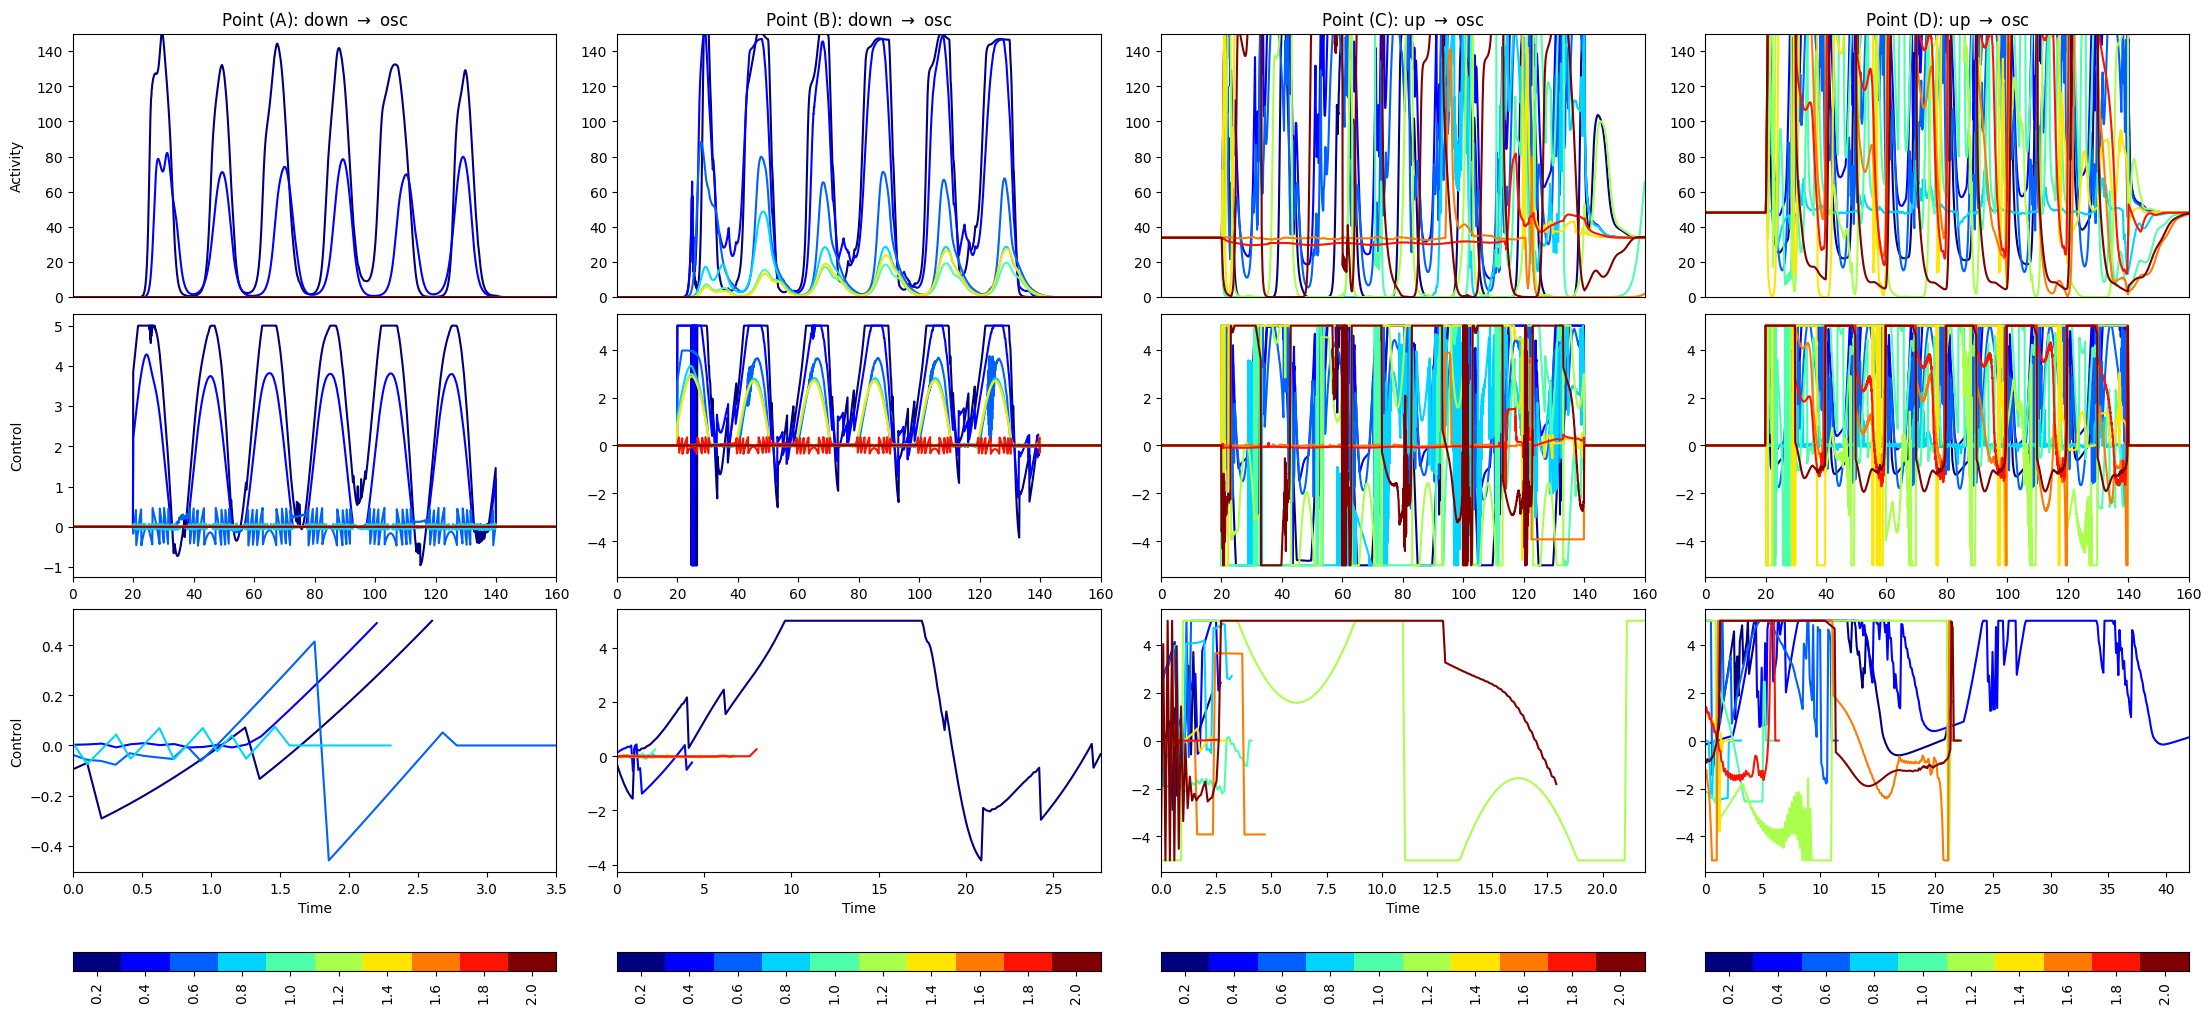

In [73]:
indzoom = np.zeros((len(p_names), len(data["A"]["w1"])))
indzoom[0,:] = 4
indzoom[1,:] = 6
indzoom[2,:] = 4
indzoom[3,:] = 4

plot_1n_osc([ data["A"]["state"], data["B"]["state"], data["C"]["state"], data["D"]["state"] ],
            [ data["A"]["control"], data["B"]["control"], data["C"]["control"], data["D"]["control"] ],
            duration, model.params.dt,
            [ data["A"]["w1"], data["B"]["w1"], data["C"]["w1"], data["D"]["w1"], ],
            indzoom, os.path.join(dir, "ALN_w1.pdf")
            )

In [14]:
with open(os.path.join(pickledir, 'osc_1n_aln_w1.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [10]:
with open(os.path.join(pickledir, 'osc_1n_aln_w1.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['C', 'D', 'A', 'B'])
